In [4]:
import sys, os

project_root = os.path.abspath("..")  # notebooks → project_root
sys.path.append(project_root)

from src.env_rl import ProductionLineEnv


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
import pickle
import torch

# ------------------------------------------
# Stable Baselines 3 (PyTorch RL)
# ------------------------------------------
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback

# ------------------------------------------
# Gymnasium (OpenAI Gym)
# ------------------------------------------
import gymnasium as gym

# ------------------------------------------
# src klasörünü path'e ekle
# ------------------------------------------
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

# ------------------------------------------
# RL Ortamı
# ------------------------------------------
from src.env_rl import ProductionLineEnv

# ------------------------------------------
# PyTorch LSTM Modeli
# ------------------------------------------
from src.lstm_torch import create_lstm_torch


In [6]:
import pickle
import torch
import pandas as pd
import numpy as np
import os, sys

# -------------------------
# 1) Veri
# -------------------------
df = pd.read_csv("../data/simulated/line_data.csv")

# -------------------------
# 2) PyTorch LSTM modeli yükle
# -------------------------
from src.lstm_torch import create_lstm_torch

model = create_lstm_torch()      # aynı mimariyi oluştur
model.load_state_dict(torch.load("../models/lstm_lead_time.pt"))
model.eval()

# -------------------------
# 3) Scaler yükle
# -------------------------
with open("../models/lstm_scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

# -------------------------
# 4) Lead-time serisini hazırla
# -------------------------
series = df["lead_time"].values.reshape(-1, 1)
series_scaled = scaler.transform(series).flatten()

print("Model + Scaler yüklendi ")


Model + Scaler yüklendi 


c:\Users\Casper\Desktop\RLveZS\rl310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.8.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [7]:
def lstm_predict_fn(t_index, window=10):
    if t_index < window:
        return float(df["lead_time"].iloc[t_index])

    seq = series_scaled[t_index-window:t_index].reshape(1, window, 1)
    seq = torch.tensor(seq, dtype=torch.float32)

    with torch.no_grad():
        pred_scaled = model(seq).item()

    pred_unscaled = scaler.inverse_transform([[pred_scaled]])[0][0]
    return float(pred_unscaled)


In [8]:
from src.env_rl import ProductionLineEnv
env = ProductionLineEnv(df, lstm_predict_fn)



In [9]:
class RLTrainingLogger(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []
        self.episode_lengths = []
        self.entropies = []
        self.actions = []
        self.discounted_rewards = []

    def _on_step(self) -> bool:
        info = self.locals

        # reward
        reward = info["rewards"][0]
        self.episode_rewards.append(reward)

        # action
        action = info["actions"][0]
        self.actions.append(action)

        # entropy
        entropy = float(self.model.policy.entropy(self.model.policy.obs))
        self.entropies.append(entropy)

        # episode length
        self.episode_lengths.append(1)

        # discounted reward (γ=0.99)
        if len(self.discounted_rewards) == 0:
            self.discounted_rewards.append(reward)
        else:
            self.discounted_rewards.append(self.discounted_rewards[-1] * 0.99 + reward)

        return True


In [10]:
import torch
print("Torch:", torch.__version__)

import torch._dynamo
print("Dynamo OK")

from stable_baselines3 import PPO
print("SB3 OK")

ppo_model = PPO("MlpPolicy", env)


Torch: 2.9.1+cpu
Dynamo OK
SB3 OK


In [11]:
ppo_model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=0.0003,
    gamma=0.99,
    n_steps=512,
)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [12]:
import sys, os
project_root = os.path.abspath("..")
sys.path.append(project_root)


In [13]:
import importlib
import src.env_rl
importlib.reload(src.env_rl)

from src.env_rl import ProductionLineEnv


In [14]:
import inspect
inspect.signature(ProductionLineEnv.reset)


<Signature (self, *, seed=None, options=None)>

In [15]:
import sys, os, importlib
project_root = os.path.abspath("..")
sys.path.append(project_root)


In [16]:
import src.env_rl
importlib.reload(src.env_rl)
from src.env_rl import ProductionLineEnv


In [17]:
import inspect
inspect.signature(ProductionLineEnv.reset)


<Signature (self, *, seed=None, options=None)>

In [18]:
import src.env_rl
print(src.env_rl.__file__)


c:\Users\Casper\Desktop\RLveZS\src\env_rl.py


In [19]:
import sys, os, importlib
project_root = os.path.abspath("..")
sys.path.append(project_root)

import src.env_rl
importlib.reload(src.env_rl)

from src.env_rl import ProductionLineEnv


In [20]:
import inspect
inspect.signature(ProductionLineEnv.reset)


<Signature (self, *, seed=None, options=None)>

In [21]:
import os
os.getcwd()


'c:\\Users\\Casper\\Desktop\\RLveZS\\notebooks'

In [22]:
import os

for root, dirs, files in os.walk("..", topdown=True):
    for f in files:
        if f.lower().endswith(".csv"):
            print(os.path.join(root, f))


..\data\simulated\line_data.csv


..\rl310\Lib\site-packages\matplotlib\mpl-data\sample_data\data_x_x2_x3.csv
..\rl310\Lib\site-packages\matplotlib\mpl-data\sample_data\msft.csv
..\rl310\Lib\site-packages\matplotlib\mpl-data\sample_data\Stocks.csv
..\rl310\Lib\site-packages\numpy\random\tests\data\mt19937-testset-1.csv
..\rl310\Lib\site-packages\numpy\random\tests\data\mt19937-testset-2.csv
..\rl310\Lib\site-packages\numpy\random\tests\data\pcg64-testset-1.csv
..\rl310\Lib\site-packages\numpy\random\tests\data\pcg64-testset-2.csv
..\rl310\Lib\site-packages\numpy\random\tests\data\pcg64dxsm-testset-1.csv
..\rl310\Lib\site-packages\numpy\random\tests\data\pcg64dxsm-testset-2.csv
..\rl310\Lib\site-packages\numpy\random\tests\data\philox-testset-1.csv
..\rl310\Lib\site-packages\numpy\random\tests\data\philox-testset-2.csv
..\rl310\Lib\site-packages\numpy\random\tests\data\sfc64-testset-1.csv
..\rl310\Lib\site-packages\numpy\random\tests\data\sfc64-testset-2.csv
..\rl310\Lib\site-packages\numpy\_core\tests\data\umath-valida

In [23]:
df.columns


Index(['time', 'step', 'hour', 'shift_id', 'normal_queue', 'priority_queue',
       'wip_total', 'completed_jobs', 'defect_rate', 'defects',
       'energy_consumption', 'operator_load', 'operator_skill',
       'operator_fatigue', 'machine_A_status', 'machine_B_status',
       'machine_C_status', 'machine_A_speed', 'machine_B_speed',
       'machine_C_speed', 'maintenance_A', 'maintenance_B', 'maintenance_C',
       'demand_spike_flag', 'queue_length', 'lead_time', 'machine_status'],
      dtype='object')

In [24]:
import importlib
import src.env_rl
importlib.reload(src.env_rl)

from src.env_rl import ProductionLineEnv


In [25]:
import src.env_rl
import inspect

print(inspect.getsource(src.env_rl.ProductionLineEnv))


class ProductionLineEnv(gym.Env):
    metadata = {"render_modes": []}

    def __init__(self, df, lstm_predict_fn, window=24, target_col="wip_total"):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.predict_fn = lstm_predict_fn
        self.window = window
        self.target_col = target_col
        self.current_step = window

        # =====================================================
        # CONTINUOUS ACTION SPACE  🔥
        # =====================================================
        self.action_space = gym.spaces.Box(
            low=-1.0,
            high=1.0,
            shape=(1,),
            dtype=np.float32
        )

        self.action_scale = 1.0
        self.prev_action = 0.0

        # =====================================================
        # OBSERVATION SPACE
        # =====================================================
        self.observation_space = gym.spaces.Box(
            low=-np.inf,
            high=np.inf

In [26]:
env = ProductionLineEnv(df, lstm_predict_fn, target_col="wip_total")


In [27]:
import inspect
inspect.signature(ProductionLineEnv.__init__)


<Signature (self, df, lstm_predict_fn, window=24, target_col='wip_total')>

In [28]:
obs, info = env.reset()
print(type(obs), obs.shape, obs.dtype)
print(obs[:5])


<class 'numpy.ndarray'> (24,) float32
[7. 3. 0. 0. 0.]


In [45]:
def lstm_predict_fn(window_data: np.ndarray):
    """
    window_data: shape (window, 1) veya (window,)
    """
    x = window_data.reshape(1, -1, 1)   # (1, window, 1)
    pred = lstm_model.predict(x, verbose=0)
    return float(pred[0, 0])


In [30]:
import importlib
import src.env_rl
importlib.reload(src.env_rl)

from src.env_rl import ProductionLineEnv


In [31]:
env = ProductionLineEnv(df, lstm_predict_fn, target_col="wip_total")


In [32]:
import gymnasium as gym
import numpy as np

class ProductionLineEnv(gym.Env):
    metadata = {"render_modes": []}

    def __init__(self, df, lstm_predict_fn, window=24, target_col="wip_total"):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.predict_fn = lstm_predict_fn
        self.window = window
        self.target_col = target_col
        self.current_step = window

        #  1D observation (MlpPolicy uyumlu)
        self.observation_space = gym.spaces.Box(
            low=-np.inf, high=np.inf, shape=(window,), dtype=np.float32
        )

        # 0: azalt, 1: sabit, 2: artır (örnek)
        self.action_space = gym.spaces.Discrete(3)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = self.window

        obs = self.df.iloc[
            self.current_step - self.window:self.current_step
        ][self.target_col].values.astype(np.float32)

        return obs, {}

    def step(self, action):
        true_val = float(self.df.iloc[self.current_step][self.target_col])

        window_data = self.df.iloc[
            self.current_step - self.window:self.current_step
        ][self.target_col].values

        #  predict_fn skaler olmalı
        pred_val = float(self.predict_fn(window_data))

        #  action reward'a etki etsin
        action_effect = {-1: -1.0, 0: 0.0, 1: 1.0}[action - 1]
        adjusted_pred = pred_val + action_effect

        reward = -abs(true_val - adjusted_pred)

        self.current_step += 1
        terminated = self.current_step >= len(self.df)
        truncated = False

        if not terminated:
            next_obs = self.df.iloc[
                self.current_step - self.window:self.current_step
            ][self.target_col].values.astype(np.float32)
        else:
            next_obs = np.zeros(self.window, dtype=np.float32)

        return next_obs, reward, terminated, truncated, {}


In [33]:
import sys, os
import numpy as np
import pandas as pd

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

from src.env_rl import ProductionLineEnv

df = pd.read_csv(r"C:\Users\Casper\Desktop\RLveZS\data\simulated\line_data.csv")

def lstm_predict_fn(window):
    return float(np.mean(window))

env = ProductionLineEnv(df, lstm_predict_fn, target_col="wip_total")


In [34]:
obs, _ = env.reset()
print(type(obs), obs.shape, obs.dtype)


<class 'numpy.ndarray'> (24,) float32


In [35]:
import numpy as np
import pandas as pd
from src.env_rl import ProductionLineEnv

df = pd.read_csv(r"C:\Users\Casper\Desktop\RLveZS\data\simulated\line_data.csv")

def lstm_predict_fn(window):
    return float(np.mean(window))

env = ProductionLineEnv(df, lstm_predict_fn)



In [36]:
obs, _ = env.reset()
print(type(obs), obs.shape, obs.dtype)


<class 'numpy.ndarray'> (24,) float32


In [37]:
import sys
!{sys.executable} -m pip install gym==0.26.2


  Using cached gym-0.26.2-py3-none-any.whl


In [41]:
def make_env():
    return ProductionLineEnv(
        df=df,
        lstm_predict_fn=lstm_predict_fn
    )


In [46]:
# ============================================================
# IMPORTS
# ============================================================
import numpy as np
import pandas as pd
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize
from stable_baselines3.common.callbacks import BaseCallback

from src.env_rl import ProductionLineEnv   # ← ENV BURADAN


# ============================================================
# DATA
# ============================================================
df = pd.read_csv(
    r"C:\Users\Casper\Desktop\RLveZS\data\simulated\line_data.csv"
)


# ============================================================
# DUMMY LSTM (ŞİMDİLİK)
# ============================================================
def lstm_predict_fn(window):
    return float(np.mean(window))


# ============================================================
# ENV FACTORY
# ============================================================
def make_env():
    return ProductionLineEnv(
        df=df,
        lstm_predict_fn=lstm_predict_fn
    )


# ============================================================
# VEC ENV  (🔥 ÖNCE BU)
# ============================================================
venv = make_vec_env(
    make_env,
    n_envs=1
)


# ============================================================
# VEC NORMALIZE (🔥 SONRA BU)
# ============================================================
venv = VecNormalize(
    venv,
    norm_obs=True,
    norm_reward=True,
    clip_obs=10.0,
    clip_reward=10.0
)


# ============================================================
# CALLBACK (METRİK İZLEME)
# ============================================================
class ErrorLogger(BaseCallback):
    def __init__(self, every=1000, verbose=0):
        super().__init__(verbose)
        self.every = every
        self.errors = []

    def _on_step(self) -> bool:
        infos = self.locals.get("infos", [])
        for info in infos:
            if "abs_err" in info:
                self.errors.append(info["abs_err"])

        if self.n_calls % self.every == 0 and self.errors:
            print(
                f"[step {self.num_timesteps}] "
                f"mean_abs_err(last 500): {np.mean(self.errors[-500:]):.4f}"
            )
        return True


# ============================================================
# PPO
# ============================================================
model = PPO(
    "MlpPolicy",
    venv,
    verbose=1,
    n_steps=256,
    batch_size=64,
    learning_rate=3e-4,
    gamma=0.99,
    gae_lambda=0.95,
    device="cpu"
)

logger = ErrorLogger(every=1000)

model.learn(
    total_timesteps=30_000,
    callback=logger
)

print(" Eğitim sorunsuz tamamlandı")


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1287 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 256  |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 999          |
|    iterations           | 2            |
|    time_elapsed         | 0            |
|    total_timesteps      | 512          |
| train/                  |              |
|    approx_kl            | 0.0014055355 |
|    clip_fraction        | 0.00937      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | -0.23494291  |
|    learning_rate        | 0.0003       |
|    loss                 | 3.52         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00274     |
|    std                  | 1            |
|    value_loss           | 3.29         |

In [39]:
import stable_baselines3 as sb3
import gymnasium as gym
import numpy as np
import sys

print("Python:", sys.executable)
print("SB3:", sb3.__version__)
print("Gymnasium:", gym.__version__)
print("NumPy:", np.__version__)


Python: c:\Users\Casper\Desktop\RLveZS\rl310\Scripts\python.exe
SB3: 2.2.1
Gymnasium: 0.29.1
NumPy: 2.2.6


In [50]:
print("VecEnv action_space:", venv.action_space)
print("Raw env action_space:", venv.envs[0].action_space)

a_vec = venv.action_space.sample()
a_raw = venv.envs[0].action_space.sample()

print("vec action:", a_vec)   # [[0.23]]
print("raw action:", a_raw)   # [0.23]


VecEnv action_space: Box(-1.0, 1.0, (1,), float32)
Raw env action_space: Box(-1.0, 1.0, (1,), float32)
vec action: [0.9521296]
raw action: [-0.66550946]


In [51]:
model = PPO(
    "MlpPolicy",
    venv,
    verbose=1,
    learning_rate=3e-4,
    n_steps=512,
    batch_size=128,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.01,
    device="cpu",
)

logger = ErrorLogger(every=1000)

model.learn(total_timesteps=30_000, callback=logger)
model.save("../models/ppo_model.zip")


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1544 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 512  |
-----------------------------
[step 1000] mean_abs_err(last 500): 14.2938
-------------------------------------------
| time/                   |               |
|    fps                  | 1324          |
|    iterations           | 2             |
|    time_elapsed         | 0             |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 0.00017122121 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.42         |
|    explained_variance   | 0.23411626    |
|    learning_rate        | 0.0003        |
|    loss                 | 0.0729        |
|    n_updates            | 10            |
|    policy_gradient_loss | -8.26e-05     |
|    std                 

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [52]:
model = PPO(
    "MlpPolicy",
    venv,
    verbose=1,
    learning_rate=3e-4,
    n_steps=512,
    batch_size=128,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.01,
    device="cpu",
)

logger = ErrorLogger(every=1000)

model.learn(total_timesteps=30_000, callback=logger)
model.save("../models/ppo_model.zip")


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1485 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 512  |
-----------------------------
[step 1000] mean_abs_err(last 500): 14.2530
------------------------------------------
| time/                   |              |
|    fps                  | 1264         |
|    iterations           | 2            |
|    time_elapsed         | 0            |
|    total_timesteps      | 1024         |
| train/                  |              |
|    approx_kl            | 0.0037245369 |
|    clip_fraction        | 0.023        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | -0.033939958 |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0797       |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00272     |
|    std                  | 1            

In [54]:
from stable_baselines3.common.callbacks import BaseCallback
import numpy as np

class ErrorLogger(BaseCallback):
    def __init__(self, every=1000, verbose=0):
        super().__init__(verbose)
        self.every = every
        self.errors = []
        self.actions = []          #  EKLENDİ
        self.rewards = []          # (opsiyonel ama faydalı)

    def _on_step(self) -> bool:
        infos = self.locals.get("infos", [])
        actions = self.locals.get("actions", None)
        rewards = self.locals.get("rewards", None)

        for i, info in enumerate(infos):
            if "abs_err" in info:
                self.errors.append(info["abs_err"])

            # 🔥 CONTINUOUS ACTION KAYDI
            if actions is not None:
                a = actions[i]
                # action shape: (1,) → float
                self.actions.append(float(np.asarray(a)[0]))

            if rewards is not None:
                self.rewards.append(float(rewards[i]))

        if self.n_calls % self.every == 0 and self.errors:
            print(
                f"[step {self.num_timesteps}] "
                f"mean_abs_err(last 500): {np.mean(self.errors[-500:]):.4f}"
            )
        return True


In [55]:
logger = ErrorLogger(every=1000)

model.learn(
    total_timesteps=30_000,
    callback=logger
)


-----------------------------
| time/              |      |
|    fps             | 1571 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 512  |
-----------------------------
[step 1000] mean_abs_err(last 500): 14.1485
-----------------------------------------
| time/                   |             |
|    fps                  | 1301        |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.002865946 |
|    clip_fraction        | 0.0324      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.35       |
|    explained_variance   | 0.23959267  |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0172      |
|    n_updates            | 600         |
|    policy_gradient_loss | -0.00485    |
|    std                  | 0.936       |
|    value_loss           | 0.06

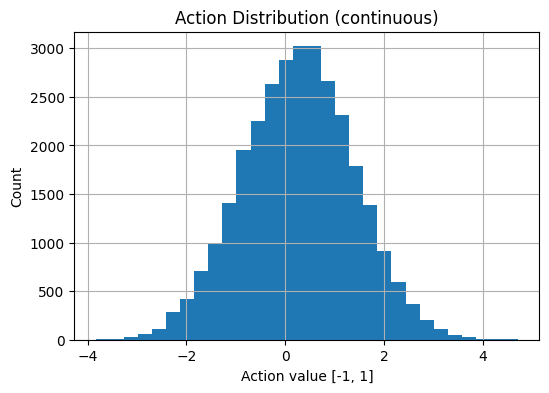

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(logger.actions, bins=30)
plt.title("Action Distribution (continuous)")
plt.xlabel("Action value [-1, 1]")
plt.ylabel("Count")
plt.grid()
plt.show()


In [57]:
env_test = ProductionLineEnv(df, lstm_predict_fn)

random_abs_err = []
state, _ = env_test.reset()

for t in range(300):
    action = env_test.action_space.sample()
    state, reward, done, _, info = env_test.step(action)
    random_abs_err.append(info["abs_err"])
    if done:
        break


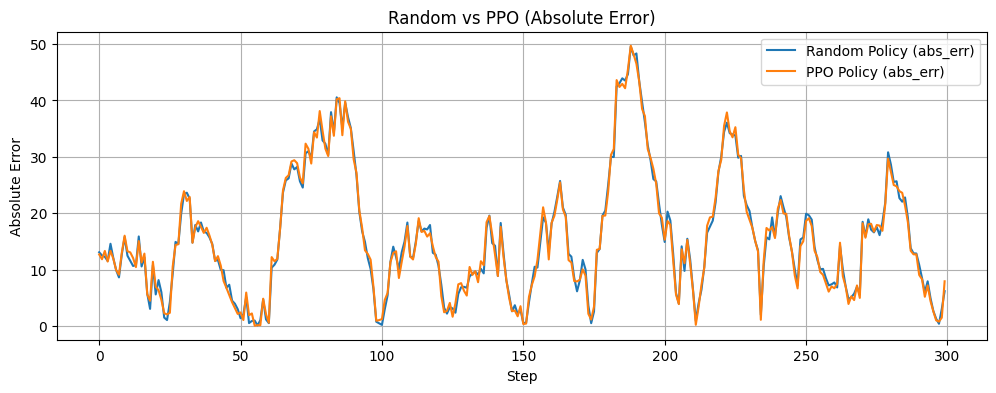

In [58]:
plt.figure(figsize=(12,4))
plt.plot(random_abs_err, label="Random Policy (abs_err)")
plt.plot(logger.errors[:len(random_abs_err)], label="PPO Policy (abs_err)")
plt.title("Random vs PPO (Absolute Error)")
plt.xlabel("Step")
plt.ylabel("Absolute Error")
plt.legend()
plt.grid()
plt.show()


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


c:\Users\Casper\Desktop\RLveZS\rl310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.8.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Using cpu device
----------------------------
| time/              |     |
|    fps             | 787 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 512 |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 730          |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 1024         |
| train/                  |              |
|    approx_kl            | 0.0001835496 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.1         |
|    explained_variance   | 0.00036      |
|    learning_rate        | 0.0003       |
|    loss                 | 1.04e+06     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.000719    |
|    value_loss           | 2.16e+06     |
------------------------------------------
------

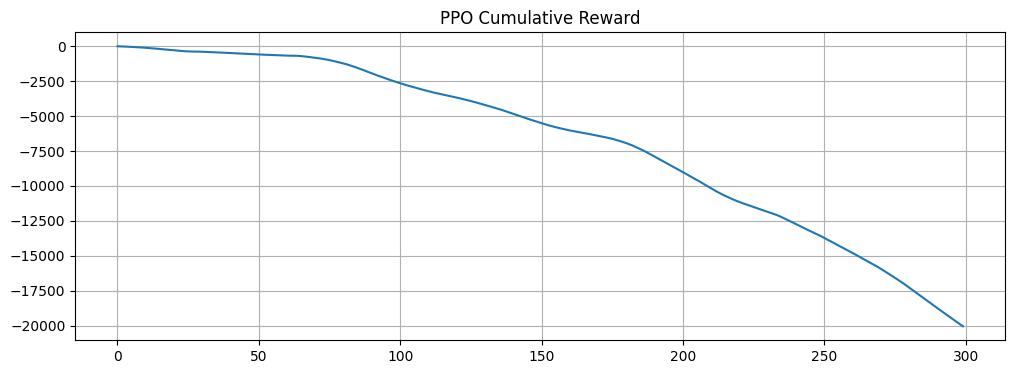

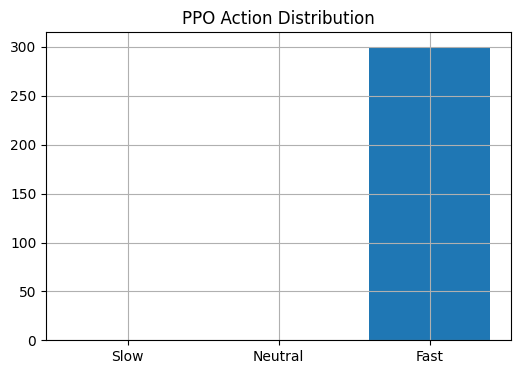

In [1]:
# ============================================================
# IMPORTS
# ============================================================
import os, sys, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

PROJECT_ROOT = os.path.abspath("..")
sys.path.append(PROJECT_ROOT)

from src.env_rl import ProductionLineEnv
from src.lstm_torch import LSTMPredictor


# ============================================================
# DATA + MODELS
# ============================================================
df = pd.read_csv("../data/simulated/line_data.csv")

with open("../models/lstm_scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

lstm_predictor = LSTMPredictor("../models/lstm_lead_time.pt")


def lstm_predict_fn(window):
    window = np.asarray(window).reshape(-1, 1)
    window_scaled = scaler.transform(window).flatten()
    return lstm_predictor.predict(window_scaled)


# ============================================================
# ENV
# ============================================================
env = make_vec_env(
    lambda: ProductionLineEnv(df, lstm_predict_fn),
    n_envs=1
)


# ============================================================
# PPO
# ============================================================
model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=3e-4,
    n_steps=512,
    batch_size=128,
    ent_coef=0.05,   #  collapse önleyici
    device="cpu"
)

model.learn(total_timesteps=30_000)
model.save("../models/ppo_model.zip")

print(" PPO eğitildi ve kaydedildi")


# ============================================================
# TEST + GRAFİK
# ============================================================
env_test = ProductionLineEnv(df, lstm_predict_fn)
obs, _ = env_test.reset()

ppo_rewards = []
ppo_actions = []

for _ in range(300):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, info = env_test.step(action)
    ppo_rewards.append(reward)
    ppo_actions.append(int(action))
    if done:
        break


plt.figure(figsize=(12,4))
plt.plot(np.cumsum(ppo_rewards))
plt.title("PPO Cumulative Reward")
plt.grid()
plt.show()


plt.figure(figsize=(6,4))
plt.hist(ppo_actions, bins=[-0.5,0.5,1.5,2.5], rwidth=0.8)
plt.xticks([0,1,2], ["Slow","Neutral","Fast"])
plt.title("PPO Action Distribution")
plt.grid()
plt.show()
